In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pandas as pd

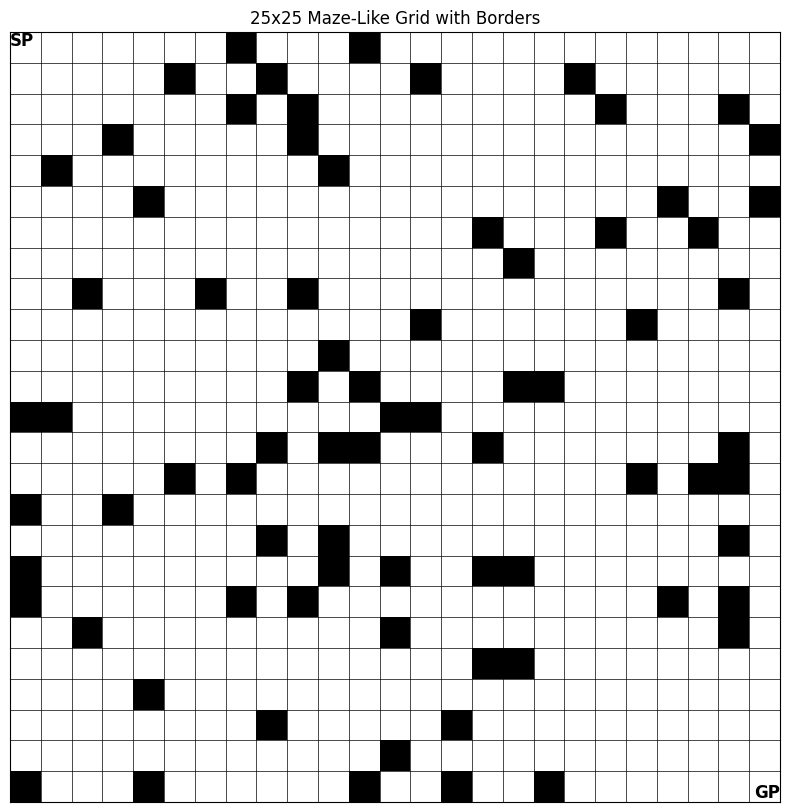

Sparse map saved as 'sparse_map.csv'


In [2]:
def generate_handcrafted_map(size=25, seed=42, obstacle_density=0.1):
    np.random.seed(seed)
    grid = np.zeros((size, size), dtype=int)

    for i in range(size):
        for j in range(size):
            if (i, j) in [(0, 0), (size - 1, size - 1)]:
                continue  # Leave SP and GP free
            if np.random.rand() < obstacle_density:
                grid[i, j] = 1

    return grid

# Generate grid
size = 25
grid = generate_handcrafted_map(size=size)

# Plot grid with cell borders
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grid, cmap='gray_r')

# Draw grid lines
for x in range(size + 1):
    ax.axhline(x - 0.5, color='black', linewidth=0.5)
    ax.axvline(x - 0.5, color='black', linewidth=0.5)

# Annotate Start and Goal
ax.text(-0.5, -0.5, "SP", fontsize=12, ha='left', va='top', fontweight='bold')
ax.text(size - 0.5, size - 0.5, "GP", fontsize=12, ha='right', va='bottom', fontweight='bold')

ax.set_xticks([]), ax.set_yticks([])
ax.set_title("25x25 Maze-Like Grid with Borders")
plt.show()

import pandas as pd

# Save grid to CSV
output_filename = "sparse_map.csv"
pd.DataFrame(grid).to_csv(output_filename, index=False, header=False)
print(f"Sparse map saved as '{output_filename}'")

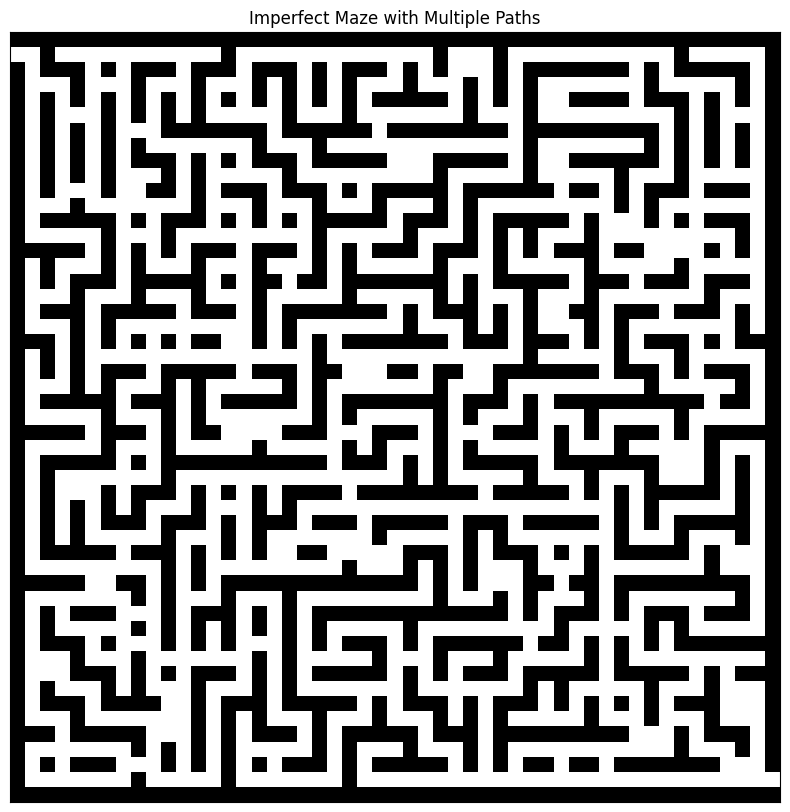

Maze saved as maze_map.csv


In [3]:
def create_imperfect_maze(dim, seed=None, loop_factor=0.05):
    if seed is not None:
        random.seed(seed)

    maze = np.ones((dim * 2 + 1, dim * 2 + 1))
    x, y = (0, 0)
    maze[2 * x + 1, 2 * y + 1] = 0

    stack = [(x, y)]
    while stack:
        x, y = stack[-1]
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < dim and 0 <= ny < dim and maze[2 * nx + 1, 2 * ny + 1] == 1:
                maze[2 * nx + 1, 2 * ny + 1] = 0
                maze[2 * x + 1 + dx, 2 * y + 1 + dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    # Add entrance and exit
    maze[1, 0] = 0
    maze[-2, -1] = 0

    # Add random loops (break some walls)
    for _ in range(int(loop_factor * dim * dim)):
        x = random.randint(1, maze.shape[0] - 2)
        y = random.randint(1, maze.shape[1] - 2)
        if maze[x, y] == 1:
            # Only knock down vertical or horizontal walls between passages
            if (maze[x-1, y] == 0 and maze[x+1, y] == 0) or (maze[x, y-1] == 0 and maze[x, y+1] == 0):
                maze[x, y] = 0

    return maze

def visualize_maze(maze, title="Imperfect Maze"):
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap='gray_r')  # white = free, black = wall
    plt.xticks([]), plt.yticks([])
    plt.title(title)
    plt.show()

dim = 25
maze = create_imperfect_maze(dim, seed=42, loop_factor=0.60)  # increase loop_factor for more paths
visualize_maze(maze, title=f"Imperfect Maze with Multiple Paths")

# Save to CSV
import pandas as pd

# Save maze as CSV
def save_maze_to_csv(maze, filename="maze_map.csv"):
    df = pd.DataFrame(maze.astype(int))  # Ensure 0/1 format (integers)
    df.to_csv(filename, index=False, header=False)
    print(f"Maze saved as {filename}")

# Save the maze
save_maze_to_csv(maze)


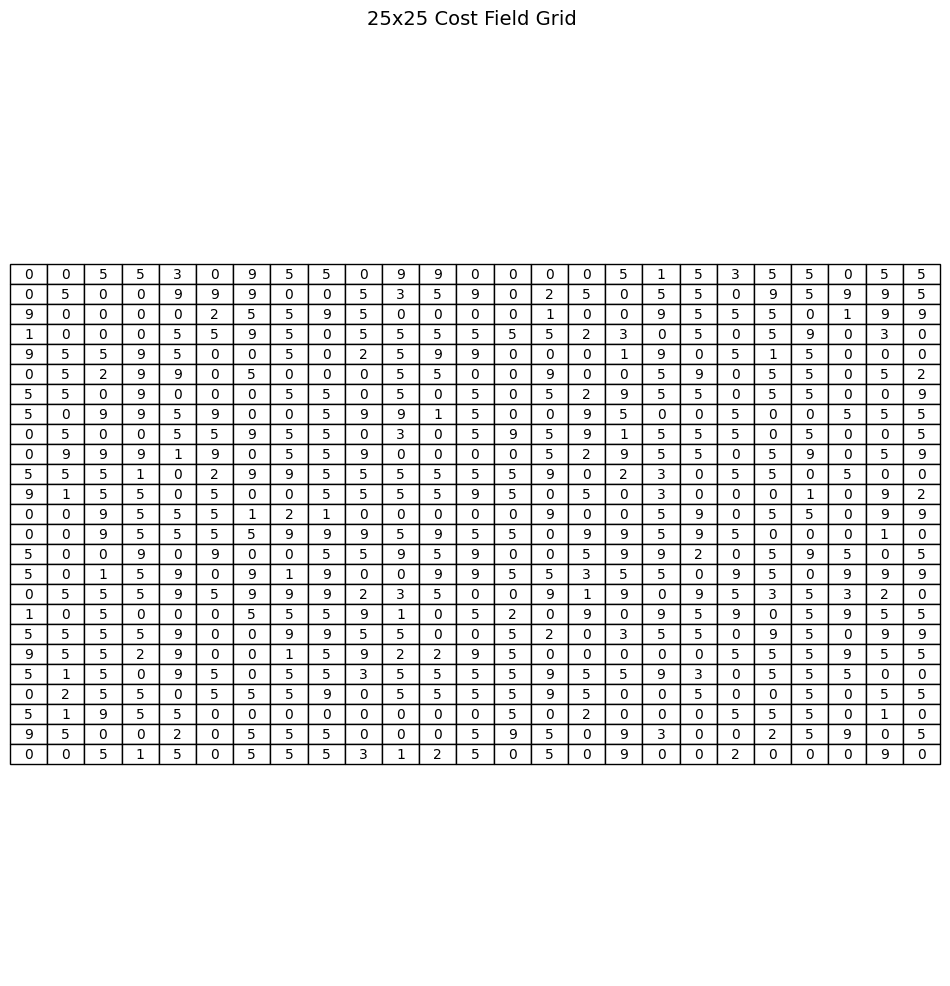

In [4]:
def generate_cost_field_map(size=25, seed=42):
    np.random.seed(seed)
    grid = np.zeros((size, size), dtype=int)

    for i in range(size):
        for j in range(size):
            rand = np.random.rand()
            if rand < 0.35:
                grid[i, j] = 0
            elif rand < 0.45:
                grid[i, j] = np.random.choice([1, 2, 3])
            elif rand < 0.8:
                grid[i, j] = 5
            else:
                grid[i, j] = 9

    grid[0, 0] = 0
    grid[size-1, size-1] = 0
    return grid

# Generate grid
cost_map = generate_cost_field_map()

# Create a clean table-style plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')  # Hide axes

table = plt.table(
    cellText=cost_map,
    cellLoc='center',
    loc='center',
    cellColours=[['white']*25 for _ in range(25)],
    colWidths=[0.04]*25
)

# Style the table: set visible borders
table.scale(1, 1.2)
for key, cell in table.get_celld().items():
    cell.set_linewidth(1)
    cell.set_edgecolor('black')
    cell.set_fontsize(10)

plt.title("25x25 Cost Field Grid ", fontsize=14, pad=20)
plt.show()

pd.DataFrame(cost_map).to_csv("cost_field_map.csv", index=False, header=False)

In [27]:
# Dijkstra Algorithm
def dijkstra(grid, start, goal):
    rows, cols = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    dist = np.full_like(grid, np.inf, dtype=float)
    parent = np.full((rows, cols, 2), -1, dtype=int)

    dist[start] = 0
    pq = [(0, start)]  # (cost, node)

    while pq:
        cost, current = heappop(pq)
        x, y = current

        if visited[x, y]:
            continue
        visited[x, y] = True

        if current == goal:
            break

        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] != 1:
                new_cost = cost + (grid[nx, ny] if grid[nx, ny] > 1 else 1)
                if new_cost < dist[nx, ny]:
                    dist[nx, ny] = new_cost
                    parent[nx, ny] = [x, y]
                    heappush(pq, (new_cost, (nx, ny)))

    # Backtrack path
    path = []
    x, y = goal
    while (x, y) != (-1, -1) and (x, y) != start:
        path.append((x, y))
        x, y = parent[x, y]
    path.append(start)
    path.reverse()

    return path, visited


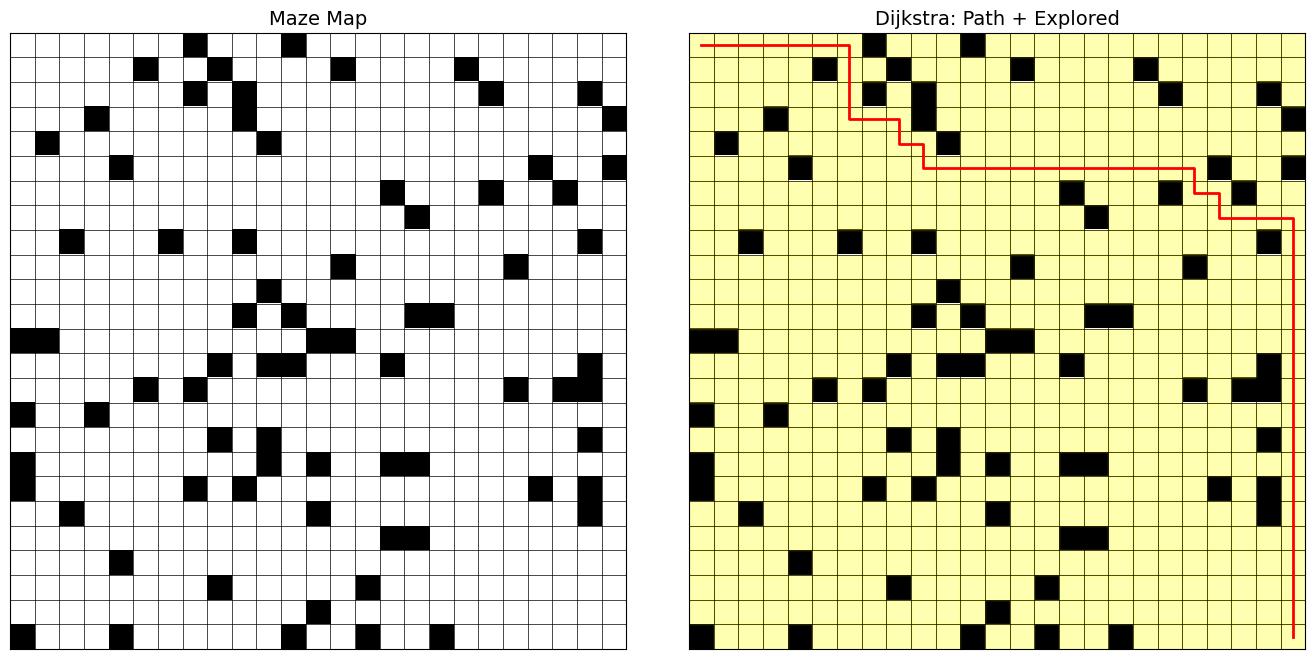

In [37]:
import time
from heapq import heappush, heappop

# Load one of your saved maps
map_path = "/content/sparse_map.csv"
grid = np.loadtxt(map_path, delimiter=',', dtype=int)

start = (0, 0)
goal = (grid.shape[0] - 1, grid.shape[1] - 1)

path, visited = dijkstra(grid, start, goal)

# Visualize path and explored nodes

# def draw_path_side_by_side(grid, path):
#     fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

#     cmap = plt.cm.gray_r
#     rows, cols = grid.shape

#     for ax_i, ax in enumerate(axs):
#         ax.imshow(grid, cmap=cmap, extent=[0, cols, 0, rows])

#         ax.set_xticks([])
#         ax.set_yticks([])

#         # Proper gridlines (based on shape)
#         for x in range(cols + 1):
#             ax.axvline(x, color='black', linewidth=0.5)
#         for y in range(rows + 1):
#             ax.axhline(y, color='black', linewidth=0.5)

#         ax.set_xlim(0, cols)
#         ax.set_ylim(0, rows)
#         ax.set_aspect('equal')

#         if ax_i == 0:
#             ax.set_title("Original Map", fontsize=14)
#         else:
#             # Fixed: use normal path coordinates, no flip
#             path_x = [y + 0.5 for x, y in path]
#             path_y = [rows - x - 0.5 for x, y in path]
#             ax.plot(path_x, path_y, color='red', linewidth=2, label='Dijkstra Path')
#             ax.set_title("Map with Dijkstra Path", fontsize=14)

#     plt.tight_layout(pad=3.0)
#     plt.show()


# draw_path_side_by_side(grid, path)

def draw_with_exploration(grid, path, visited):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

    rows, cols = grid.shape
    cmap = plt.cm.gray_r

    for ax_i, ax in enumerate(axs):
        ax.imshow(grid, cmap=cmap, extent=[0, cols, 0, rows])

        ax.set_xticks([])
        ax.set_yticks([])

        for x in range(cols + 1):
            ax.axvline(x, color='black', linewidth=0.5)
        for y in range(rows + 1):
            ax.axhline(y, color='black', linewidth=0.5)

        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')

        if ax_i == 0:
            ax.set_title("Original Map")
        else:
            ax.set_title("Map with Dijkstra Path + Explored")

            # 🔶 Draw explored cells in yellow
            for x in range(rows):
                for y in range(cols):
                    if visited[x, y] and grid[x, y] != 1:
                        ax.add_patch(plt.Rectangle((y, rows - x - 1), 1, 1, color='yellow', alpha=0.5))

            # 🔴 Draw path in red
            path_x = [y + 0.5 for x, y in path]
            path_y = [rows - x - 0.5 for x, y in path]
            ax.plot(path_x, path_y, color='red', linewidth=2)

    plt.tight_layout()
    plt.show()



draw_path_side_by_side(grid, path, visited)

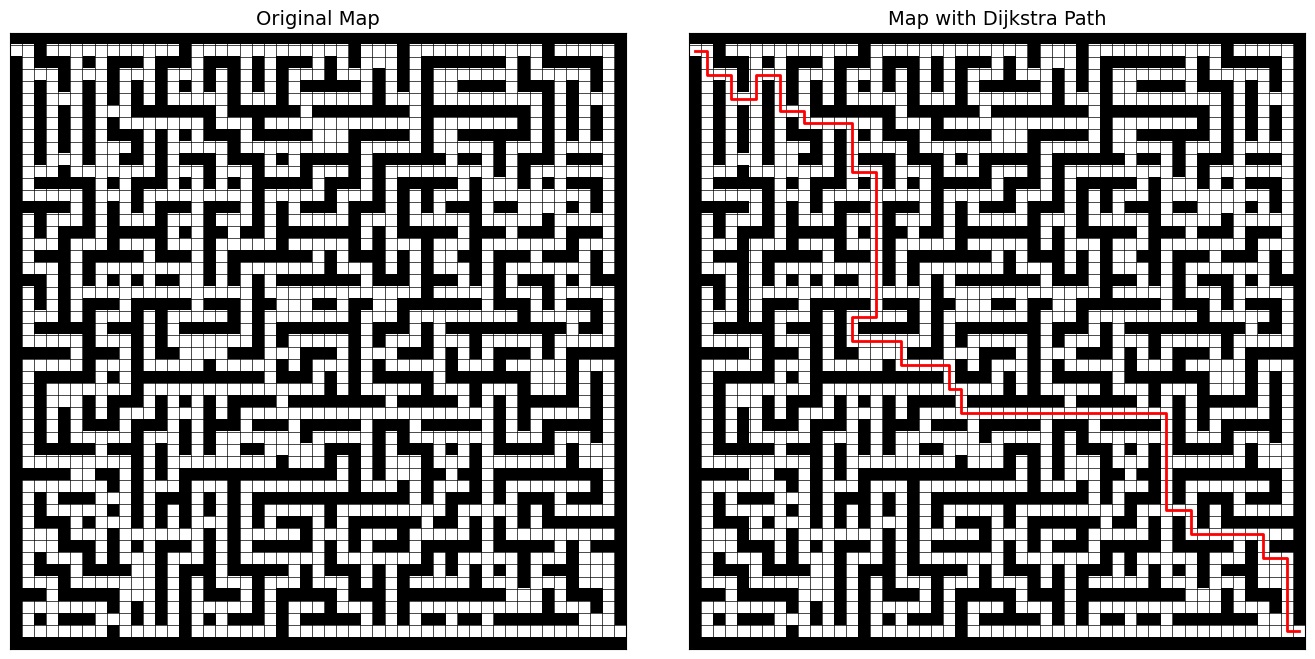

In [25]:
maze_grid = np.loadtxt("/content/maze_map.csv", delimiter=',', dtype=int)
start = (1, 0)
goal = (maze_grid.shape[0] - 2, maze_grid.shape[1] - 1)

# run dijkstra
path, visited = dijkstra(maze_grid, start, goal)


# visualization
draw_path_side_by_side(maze_grid, path)


In [31]:
maze_grid = np.loadtxt("/content/maze_map.csv", delimiter=',', dtype=int)
start = (1, 0)
goal = (maze_grid.shape[0] - 2, maze_grid.shape[1] - 1)  # adjusted goal position

In [32]:
from heapq import heappush, heappop

def dijkstra(grid, start, goal):
    rows, cols = grid.shape
    dist = np.full_like(grid, np.inf, dtype=float)
    parent = np.full((rows, cols, 2), -1, dtype=int)
    explored = set()

    dist[start] = 0
    pq = [(0, start)]

    while pq:
        cost, current = heappop(pq)
        x, y = current

        if grid[x, y] == 1 or current in explored:
            continue
        explored.add(current)

        if current == goal:
            break

        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] != 1:
                new_cost = cost + (grid[nx, ny] if grid[nx, ny] > 1 else 1)
                if new_cost < dist[nx, ny]:
                    dist[nx, ny] = new_cost
                    parent[nx, ny] = [x, y]
                    heappush(pq, (new_cost, (nx, ny)))

    # Backtrack path
    path = []
    x, y = goal
    while (x, y) != (-1, -1) and (x, y) != start:
        path.append((x, y))
        x, y = parent[x, y]
    if (x, y) == start:
        path.append(start)
        path.reverse()
    else:
        path = []

    return path, explored


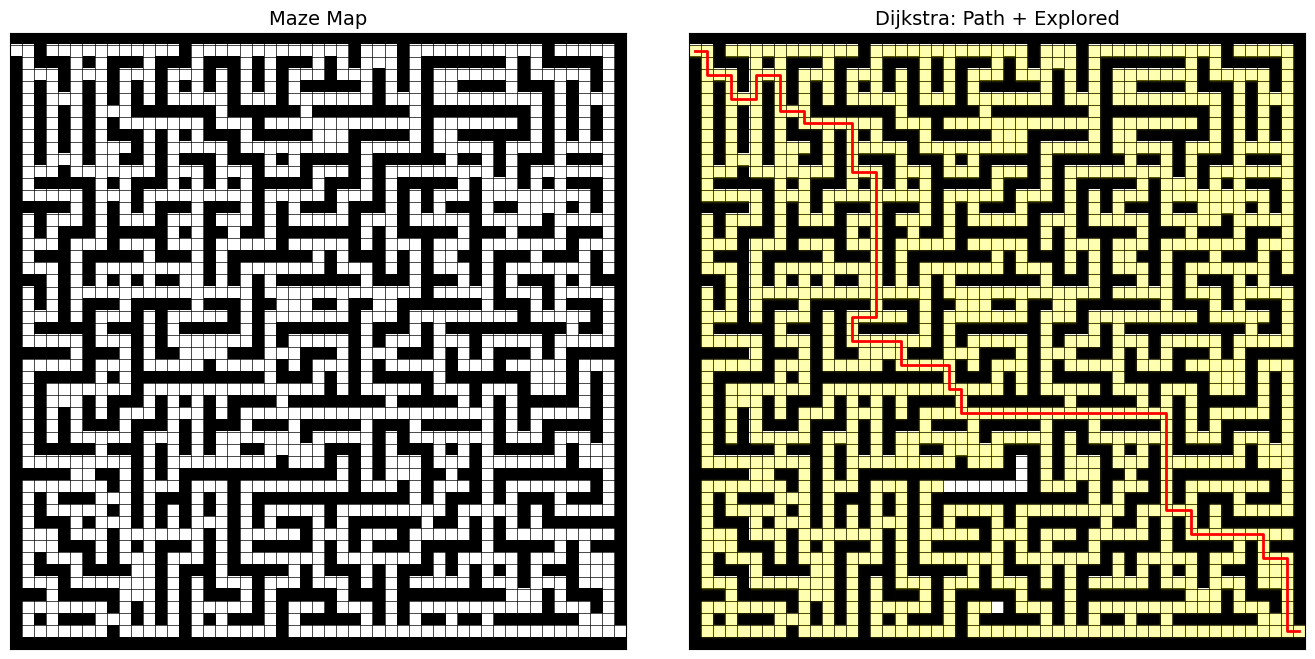

In [33]:
import matplotlib.pyplot as plt

def draw_path_side_by_side(grid, path, explored):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

    rows, cols = grid.shape
    cmap = plt.cm.gray_r

    for ax_i, ax in enumerate(axs):
        ax.imshow(grid, cmap=cmap, extent=[0, cols, 0, rows])
        ax.set_xticks([]); ax.set_yticks([])

        for x in range(cols + 1):
            ax.axvline(x, color='black', linewidth=0.5)
        for y in range(rows + 1):
            ax.axhline(y, color='black', linewidth=0.5)

        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')

        if ax_i == 0:
            ax.set_title("Maze Map", fontsize=14)
        else:
            ax.set_title("Dijkstra: Path + Explored", fontsize=14)

            # Yellow patches for explored
            for x, y in explored:
                if grid[x, y] != 1:
                    ax.add_patch(plt.Rectangle((y, rows - x - 1), 1, 1, color='yellow', alpha=0.3))

            # Red path line
            if path:
                path_x = [y + 0.5 for x, y in path]
                path_y = [rows - x - 0.5 for x, y in path]
                ax.plot(path_x, path_y, color='red', linewidth=2)

    plt.tight_layout(pad=3.0)
    plt.show()

path, explored = dijkstra(maze_grid, start, goal)
draw_path_side_by_side(maze_grid, path, explored)


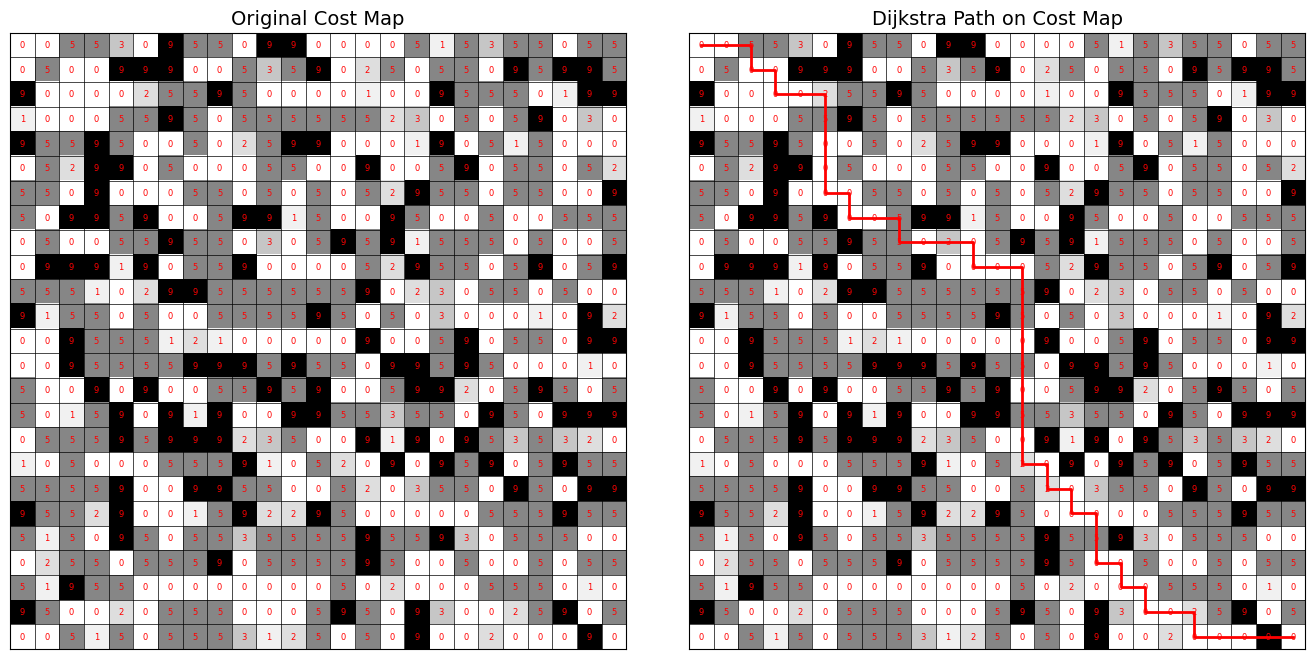

In [100]:
# cost field map
cost_grid = np.loadtxt("/content/cost_field_map.csv", delimiter=',', dtype=int)

start = (0, 0)
goal = (cost_grid.shape[0] - 1, cost_grid.shape[1] - 1)

# run dijkstra
path, visited = dijkstra(cost_grid, start, goal)

def draw_2(grid, path):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

    rows, cols = grid.shape
    cmap = plt.cm.Greys  # or 'plasma', 'viridis', etc. for color scale
    norm = plt.Normalize(vmin=np.min(grid), vmax=np.max(grid))  # use actual range

    for ax_i, ax in enumerate(axs):
        ax.imshow(grid, cmap=cmap, norm=norm, extent=[0, cols, 0, rows])

        # Draw gridlines
        for x in range(cols + 1):
            ax.axvline(x, color='black', linewidth=0.5)
        for y in range(rows + 1):
            ax.axhline(y, color='black', linewidth=0.5)

        # Overlay cost values in each cell
        for x in range(rows):
            for y in range(cols):
                val = grid[x, y]
                # if val > 0:
                ax.text(y + 0.5, rows - x - 0.5, str(val), va='center', ha='center', fontsize=6, color='Red')

        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        if ax_i == 0:
            ax.set_title("Original Cost Map", fontsize=14)
        else:
            # Draw path
            path_x = [y + 0.5 for x, y in path]
            path_y = [rows - x - 0.5 for x, y in path]
            ax.plot(path_x, path_y, color='red', linewidth=2)
            ax.set_title("Dijkstra Path on Cost Map", fontsize=14)

    plt.tight_layout(pad=3.0)
    plt.show()

# visualization
draw_2(cost_grid, path)

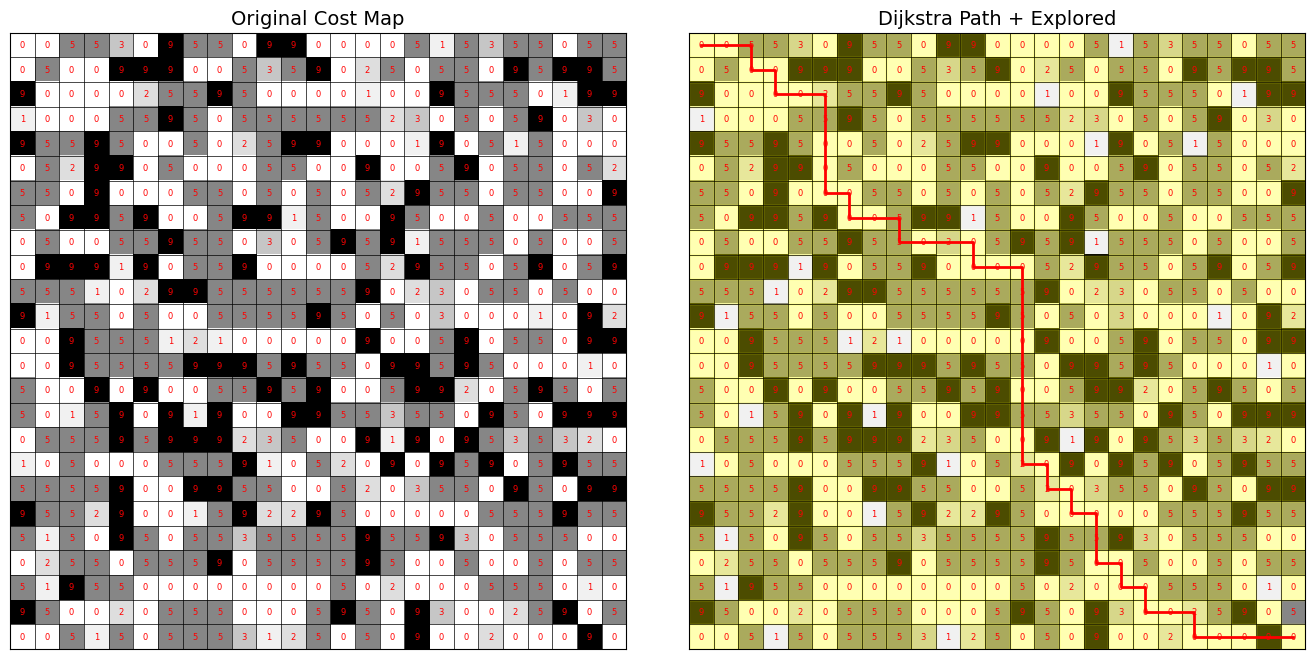

In [35]:
def draw_2(grid, path, explored):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

    rows, cols = grid.shape
    cmap = plt.cm.Greys
    norm = plt.Normalize(vmin=np.min(grid), vmax=np.max(grid))

    for ax_i, ax in enumerate(axs):
        ax.imshow(grid, cmap=cmap, norm=norm, extent=[0, cols, 0, rows])

        for x in range(cols + 1):
            ax.axvline(x, color='black', linewidth=0.5)
        for y in range(rows + 1):
            ax.axhline(y, color='black', linewidth=0.5)

        # Overlay cost values
        for x in range(rows):
            for y in range(cols):
                val = grid[x, y]
                ax.text(y + 0.5, rows - x - 0.5, str(val), va='center', ha='center', fontsize=6, color='red')

        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        if ax_i == 0:
            ax.set_title("Original Cost Map", fontsize=14)
        else:
            ax.set_title("Dijkstra Path + Explored", fontsize=14)

            # Draw explored cells
            for x, y in explored:
                if grid[x, y] != 1:
                    ax.add_patch(plt.Rectangle((y, rows - x - 1), 1, 1, color='yellow', alpha=0.3))

            # Draw path
            path_x = [y + 0.5 for x, y in path]
            path_y = [rows - x - 0.5 for x, y in path]
            ax.plot(path_x, path_y, color='red', linewidth=2)

    plt.tight_layout(pad=3.0)
    plt.show()

cost_grid = np.loadtxt("/content/cost_field_map.csv", delimiter=',', dtype=int)

start = (0, 0)
goal = (cost_grid.shape[0] - 1, cost_grid.shape[1] - 1)

path, explored = dijkstra(cost_grid, start, goal)
draw_2(cost_grid, path, explored)


In [42]:
import numpy as np, time
from heapq import heappush, heappop

# helper functions
def find_first_free(grid):
    return next(((i, j) for i in range(grid.shape[0]) for j in range(grid.shape[1]) if grid[i, j] != 1), None)
def find_last_free(grid):
    return next(((i, j) for i in reversed(range(grid.shape[0])) for j in reversed(range(grid.shape[1])) if grid[i, j] != 1), None)

# === Benchmark ===
maps = {
    "sparse_map": "/content/sparse_map.csv",
    "maze_map": "/content/maze_map.csv",
    "cost_field_map": "/content/cost_field_map.csv"
}

results = []

for name, path_ in maps.items():
    times, lengths, successes = [], [], []
    grid = np.loadtxt(path_, delimiter=',', dtype=int)
    for _ in range(5):
        start, goal = find_first_free(grid), find_last_free(grid)
        if not start or not goal: continue
        t0 = time.time()
        path, visited = dijkstra(grid, start, goal)
        t1 = time.time()
        success = bool(path)
        times.append((t1 - t0) * 1000)
        lengths.append(len(path) if success else 0)
        successes.append(int(success))
    print(f"{name}: avg_time={np.mean(times):.2f} ms | avg_len={np.mean(lengths):.1f} | success={sum(successes)}/5")


sparse_map: avg_time=2.52 ms | avg_len=49.0 | success=5/5
maze_map: avg_time=5.61 ms | avg_len=107.0 | success=5/5
cost_field_map: avg_time=3.45 ms | avg_len=49.0 | success=5/5


A* Algorithm

In [43]:
# ---------- Heuristic (Manhattan) ----------
def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# ---------- A* Algorithm ----------
def astar(grid, start, goal):
    rows, cols = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    dist = np.full((rows, cols), np.inf)
    parent = np.full((rows, cols, 2), -1)

    dist[start] = 0
    pq = [(manhattan(start, goal), 0, start)]  # (f = g + h, g, node)

    while pq:
        _, cost, (x, y) = heappop(pq)
        if visited[x, y]: continue
        visited[x, y] = True
        if (x, y) == goal: break

        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] != 1:
                move_cost = grid[nx, ny] if grid[nx, ny] > 1 else 1
                new_cost = cost + move_cost
                if new_cost < dist[nx, ny]:
                    dist[nx, ny] = new_cost
                    parent[nx, ny] = [x, y]
                    priority = new_cost + manhattan((nx, ny), goal)
                    heappush(pq, (priority, new_cost, (nx, ny)))

    # Backtrack path
    path = []
    x, y = goal
    while (x, y) != (-1, -1) and (x, y) != start:
        path.append((x, y))
        x, y = parent[int(x), int(y)]
    if (x, y) == start:
        path.append(start)
        path.reverse()
        return path, visited
    return [], visited

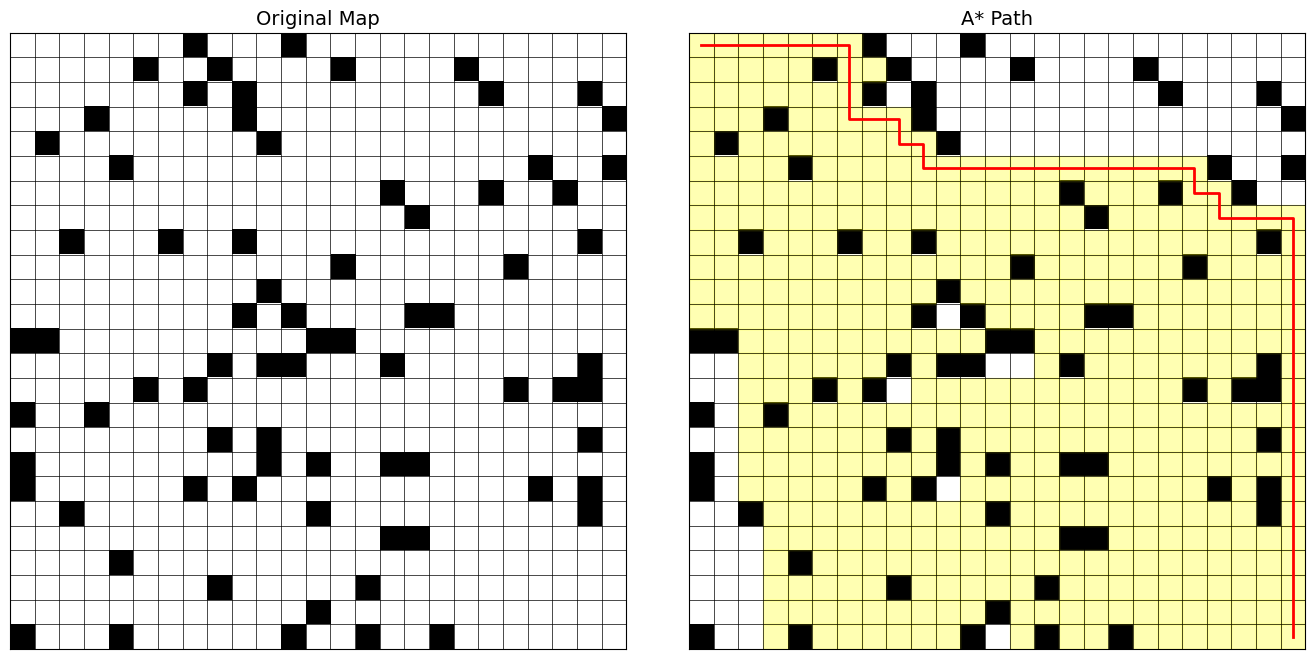

In [44]:
grid = np.loadtxt("/content/sparse_map.csv", delimiter=',', dtype=int)
start = (0, 0)
goal = (grid.shape[0] - 1, grid.shape[1] - 1)

path, visited = astar(grid, start, goal)

def draw_path_side_by_side(grid, path, visited=None):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)
    rows, cols = grid.shape
    cmap = plt.cm.gray_r

    for i, ax in enumerate(axs):
        ax.imshow(grid, cmap=cmap, extent=[0, cols, 0, rows])
        ax.set_xticks([]); ax.set_yticks([])

        for x in range(cols + 1):
            ax.axvline(x, color='black', linewidth=0.5)
        for y in range(rows + 1):
            ax.axhline(y, color='black', linewidth=0.5)

        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')

        if i == 0:
            ax.set_title("Original Map", fontsize=14)
        else:
            ax.set_title("A* Path", fontsize=14)

            if visited is not None:
                for x in range(rows):
                    for y in range(cols):
                        if visited[x, y]:
                            ax.add_patch(plt.Rectangle((y, rows - x - 1), 1, 1, color='yellow', alpha=0.3))

            path_x = [y + 0.5 for x, y in path]
            path_y = [rows - x - 0.5 for x, y in path]
            ax.plot(path_x, path_y, color='red', linewidth=2)

    plt.tight_layout(pad=3.0)
    plt.show()


draw_path_side_by_side(grid, path, visited)

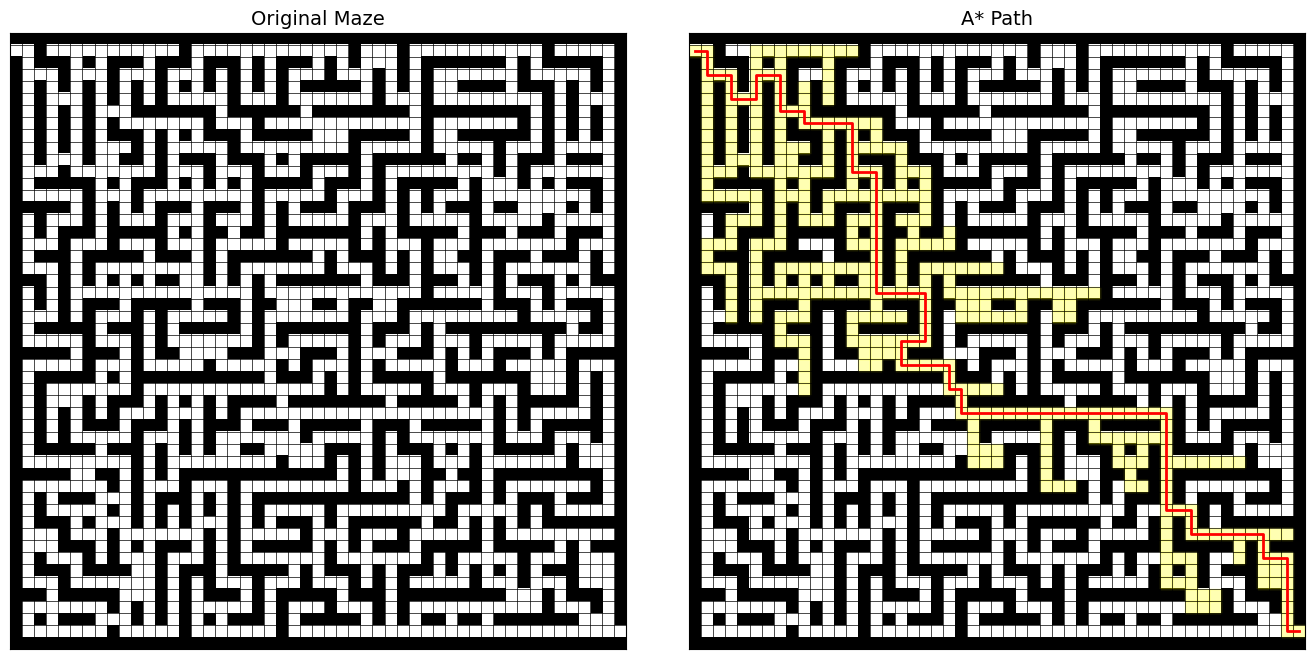

In [48]:
maze_grid = np.loadtxt("/content/maze_map.csv", delimiter=',', dtype=int)
start = (1, 0)
goal = (maze_grid.shape[0] - 2, maze_grid.shape[1] - 1)

path, visited = astar(maze_grid, start, goal)

def draw_path_side_by_side(grid, path, visited=None):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)
    rows, cols = grid.shape
    cmap = plt.cm.gray_r

    for i, ax in enumerate(axs):
        ax.imshow(grid, cmap=cmap, extent=[0, cols, 0, rows])
        ax.set_xticks([]); ax.set_yticks([])

        for x in range(cols + 1):
            ax.axvline(x, color='black', linewidth=0.5)
        for y in range(rows + 1):
            ax.axhline(y, color='black', linewidth=0.5)

        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')

        if i == 0:
            ax.set_title("Original Maze", fontsize=14)
        else:
            ax.set_title("A* Path", fontsize=14)

            if visited is not None:
                for x in range(rows):
                    for y in range(cols):
                        if visited[x, y] and grid[x, y] == 0:
                            ax.add_patch(plt.Rectangle((y, rows - x - 1), 1, 1, color='yellow', alpha=0.3))

            path_x = [y + 0.5 for x, y in path]
            path_y = [rows - x - 0.5 for x, y in path]
            ax.plot(path_x, path_y, color='red', linewidth=2)

    plt.tight_layout(pad=3.0)
    plt.show()

draw_path_side_by_side(maze_grid, path, visited)

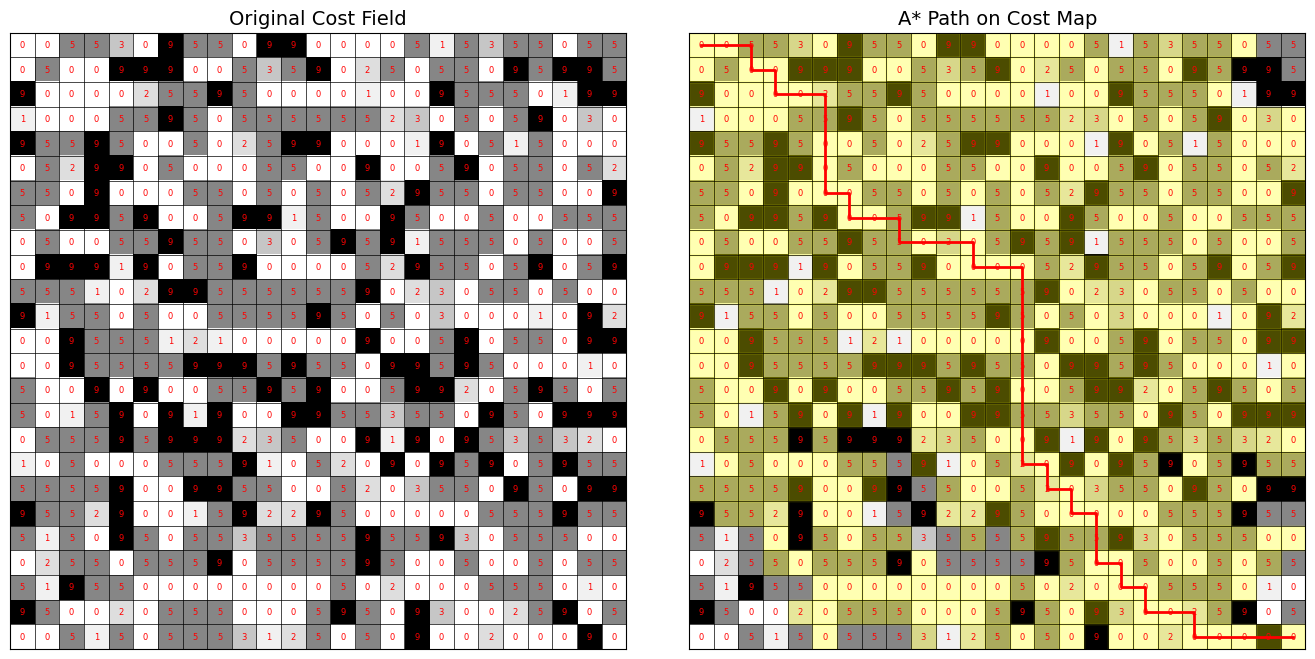

In [51]:
cost_grid = np.loadtxt("/content/cost_field_map.csv", delimiter=',', dtype=int)
start = (0, 0)
goal = (cost_grid.shape[0] - 1, cost_grid.shape[1] - 1)

path, visited = astar(cost_grid, start, goal)

def draw_cost_map_with_path(grid, path, visited):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=100)

    rows, cols = grid.shape
    cmap = plt.cm.Greys
    norm = plt.Normalize(vmin=np.min(grid), vmax=np.max(grid))

    for ax_i, ax in enumerate(axs):
        ax.imshow(grid, cmap=cmap, norm=norm, extent=[0, cols, 0, rows])
        ax.set_xticks([]); ax.set_yticks([])

        for x in range(cols + 1):
            ax.axvline(x, color='black', linewidth=0.5)
        for y in range(rows + 1):
            ax.axhline(y, color='black', linewidth=0.5)

        # Display cost values
        for x in range(rows):
            for y in range(cols):
                ax.text(y + 0.5, rows - x - 0.5, str(grid[x, y]),
                        ha='center', va='center', fontsize=6, color='red')

        if ax_i == 0:
            ax.set_title("Original Cost Field", fontsize=14)
        else:
            ax.set_title("A* Path on Cost Map", fontsize=14)
            # Explored cells
            for x in range(rows):
                for y in range(cols):
                    if visited[x, y]:
                        ax.add_patch(plt.Rectangle((y, rows - x - 1), 1, 1, color='yellow', alpha=0.3))

            # Path overlay
            path_x = [y + 0.5 for x, y in path]
            path_y = [rows - x - 0.5 for x, y in path]
            ax.plot(path_x, path_y, color='red', linewidth=2)

        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')

    plt.tight_layout(pad=3.0)
    plt.show()


draw_cost_map_with_path(cost_grid, path, visited)


In [59]:
# --- Helper ---
def find_first_free(grid):
    return next(((i, j) for i in range(grid.shape[0]) for j in range(grid.shape[1]) if grid[i, j] != 1), None)
def find_last_free(grid):
    return next(((i, j) for i in reversed(range(grid.shape[0])) for j in reversed(range(grid.shape[1])) if grid[i, j] != 1), None)

# --- Benchmark for A* ---
maps = {
    "sparse_map": "/content/sparse_map.csv",
    "maze_map": "/content/maze_map.csv",
    "cost_field_map": "/content/cost_field_map.csv"
}

results = []

for name, path_ in maps.items():
    times, lengths, successes = [], [], []
    grid = np.loadtxt(path_, delimiter=',', dtype=int)
    for _ in range(5):
        start, goal = find_first_free(grid), find_last_free(grid)
        if not start or not goal: continue
        t0 = time.time()
        path, visited = astar(grid, start, goal)
        t1 = time.time()
        success = bool(path)
        times.append((t1 - t0) * 1000)
        lengths.append(len(path) if success else 0)
        successes.append(int(success))
    print(f"{name}:   avg_time = {np.mean(times):.2f} ms | avg_len = {np.mean(lengths):.1f} | success = {sum(successes)}/5")

sparse_map:   avg_time = 2.60 ms | avg_len = 49.0 | success = 5/5
maze_map:   avg_time = 1.86 ms | avg_len = 107.0 | success = 5/5
cost_field_map:   avg_time = 3.62 ms | avg_len = 49.0 | success = 5/5
